#Solving QUBOs with DWAVE Quantum Annealing

Date: December 4th, 2023

The notebook contains materials supporting the tutorial paper:
*Five Starter Problems: Solving QUBOs on Quantum Computers* by Arul Rhik Mazumder (arulm@andrew.cmu.edu) and Sridhar Tayur (stayur@cmu.edu).
It depends on various packages shown below.

### **Introduction**

D-Wave Ocean is a software stack and suite of tools provided by D-Wave Systems, a company specializing in quantum computing hardware based on quantum annealing technology. D-Wave Ocean is designed to support the development and execution of quantum annealing applications. Quantum annealing is a specialized approach to quantum computing that focuses on solving optimization problems.

D-Wave provides cloud-based access to their quantum annealing processors through the Leap cloud service. Users can access quantum annealing resources remotely, allowing them to run optimization problems on D-Wave's hardware. Their Ocean software stack includes various software tools and libraries that help users formulate, optimize, and solve problems using quantum annealers. It provides high-level abstractions for working with quantum annealing and includes tools for problem modeling, hybrid solvers, and more. More details regarding DWAVE Ocean functionalities can be found in the link below:

https://docs.ocean.dwavesys.com/en/stable/

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  !pip install dwave-ocean-sdk
  !pip install bravado
  print("All Packages Installed!")

All Packages Installed!


In [ ]:
# imports necessary packages to run on a DWAVE Machine
from pyqubo import Spin, Array, Placeholder, Constraint
import dimod
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import neal

# Misc. imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import time
import os

# Connecting to DWAVE Account
os.environ['DWAVE_API_TOKEN'] = 'DEV-b79808e5fb947c37b1cee8f6e57040f7ae5922bb'

### **Example 1 - Number Partitioning Problem**

Initializing an arbitrary number partitioning instance.

In [ ]:
test_1 = [1, 5, 11, 5]
test_2 = [25, 7, 13, 31, 42, 17, 21, 10]
arr = test_2
print(arr)
n = len(arr)
c = sum(arr)

[25, 7, 13, 31, 42, 17, 21, 10]


**Number Partitioning Models**

Given an array of $n$ integers $[a_{1}, a_{2}, a_{3} ... a_{n}]$, the corresponding Ising Hamiltonian is:

$$H=(\sum_{i=1}^{n}a_{i}s_{i})^2$$

Where $s_{i} \in \{-1,1\}$ is the Ising spin variable.

Similarly the corresponding QUBO Model is:

$$Q=(\sum_{i=1}^{n}a_{i}-2\sum_{i=1}^{n}a_{i}x_{i})^{2}$$
or
$$Q=(c-2\sum_{i=1}^{n}a_{i}x_{i})^{2}$$

Where $c=\sum_{i=1}^{n}a_{i}$ and $x_{i} \in \{0, 1\}$ is a binary quadratic variable.

In [ ]:
x = Array.create('x', n, 'BINARY')
H = (c - 2*sum(arr[i]*x[i] for i in range(n)))**2
model = H.compile()
bqm = model.to_bqm()

Embedding and running the problem on the the DWAVE Quantum Annealer. The best solution is the first one with the lowest energy.

In [ ]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample(bqm, num_reads=1000)
sample = sampleset.first

Print sampler solving details.

In [ ]:
print(sampleset.info)
elapsed_time = float(sampleset.info['timing']['qpu_access_time'])/1000000

{'timing': {'qpu_sampling_time': 132640.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 92.1, 'qpu_access_time': 148399.57, 'qpu_access_overhead_time': 1009.43, 'qpu_programming_time': 15759.57, 'qpu_delay_time_per_sample': 20.54, 'total_post_processing_time': 278.0, 'post_processing_overhead_time': 278.0}, 'problem_id': '2be4a122-b265-48d3-bbec-2facb58216b7'}


In [ ]:
# Converting the output binary variables to produce a valid output
def NPP_measure(sortedSample):
  P1 = []
  P2 = []
  for i in sortedSample.keys():
    if sortedSample[i] == 0:
        P1.append(arr[int(i[2:len(i)-1])])
    else:
        P2.append(arr[int(i[2:len(i)-1])])
  sum1 = sum(P1[i] for i in range(len(P1)))
  sum2 = sum(P2[i] for i in range(len(P2)))
  print(P1)
  print('Sum: ' + str(sum1))
  print(P2)
  print('Sum: ' + str(sum2))
  return abs(sum2-sum1)

In [ ]:
#Sorts samples by numbers to see which quadratic variables are 0 and 1
sampleKeys = list(sample.sample.keys())
def sortbynumber(str):
    return int(str[2:len(str)-1])
sampleKeys.sort(key = sortbynumber)
sortedSample = {i: sample.sample[i] for i in sampleKeys}
#print(sortedSample)
print("QPU Access Time: " + str(elapsed_time))
NPP_measure(sortedSample)

QPU Access Time: 0.14839957
[31, 42, 10]
Sum: 83
[25, 7, 13, 17, 21]
Sum: 83


0

### **Example 2 - Max-Cut Problem**

In [ ]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")

Initializing an arbitrary Max-Cut instance.

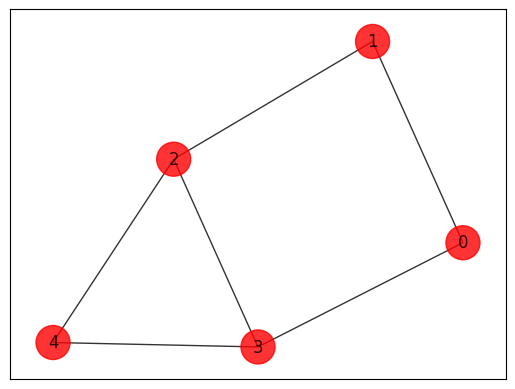

In [ ]:
# Generating a graph of 4 nodes

n = 5 # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
edges = [(0, 1, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0), (2, 4, 1.0), (3, 4, 1.0)]
G.add_weighted_edges_from(edges)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

draw_graph(G, colors, pos)

**Max-Cut Models**

Given an undirected unweighted Graph $G$ with vertex set $V$ and edge set $E$ with edges $(i, j)$ the corresponding Ising Hamiltonian is:

$$H=\sum_{(i, j) \in E}\frac{1-s_{i}s_{j}}{2}$$

Where $s_{i} \in \{-1,1\}$ is the Ising spin variable.

The corresponding QUBO Model is:

$$Q=\sum_{(i, j)\in E}(x_{i}+x_{j}-2x_{i}x_{j})$$

Where $x_{i} \in \{0, 1\}$ is a binary quadratic variable.

In [ ]:
x = Array.create('x', n, 'BINARY')
H = sum(2*x[e[0]]*x[e[1]] - x[e[0]] - x[e[1]] for e in edges)
model = H.compile()
bqm = model.to_bqm()

Embedding and running the problem on the the DWAVE Quantum Annealer.

In [ ]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample(bqm, num_reads=1000)
sample = sampleset.first

Print sampler solving details.

In [ ]:
print(sampleset.info)
elapsed_time = float(sampleset.info['timing']['qpu_access_time'])/1000000

{'timing': {'qpu_sampling_time': 96380.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 55.84, 'qpu_access_time': 112139.57, 'qpu_access_overhead_time': 814.43, 'qpu_programming_time': 15759.57, 'qpu_delay_time_per_sample': 20.54, 'total_post_processing_time': 617.0, 'post_processing_overhead_time': 617.0}, 'problem_id': '7df0e3eb-9127-467a-ad6c-ee798b807204'}


In [ ]:
#Sorts samples by numbers to see which quadratic variables are 0 and 1
sampleKeys = list(sample.sample.keys())
sampleKeys.sort(key = sortbynumber)
sortedSample = {i: sample.sample[i] for i in sampleKeys}
print(sortedSample)

{'x[0]': 0, 'x[1]': 1, 'x[2]': 0, 'x[3]': 1, 'x[4]': 1}


In [ ]:
# Converting the output binary variables to produce a valid output
def MaxCut(sortedSample):
  maxcut_sol = []
  for i in sortedSample.keys():
    if sortedSample[i] == 0:
        maxcut_sol.append(0)
    else:
        maxcut_sol.append(1)
  colors = ["r" if maxcut_sol[i] == 0 else "c" for i in range(len(maxcut_sol))]
  draw_graph(G, colors, pos)
  cutsize = 0
  for u, v in G.edges():
    if maxcut_sol[u] != maxcut_sol[v]:
      cutsize += 1
  return cutsize

QPU Access Time: 0.11213957000000001
5


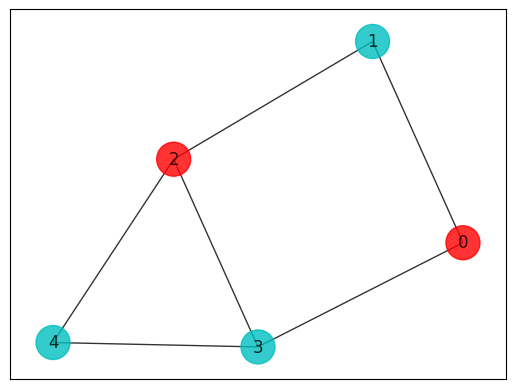

In [ ]:
print("QPU Access Time: " + str(elapsed_time))
print(MaxCut(sortedSample))

### **Example 3 - Minimum Vertex Cover**

Initializing an arbitrary Minimum Vertex Cover instance.

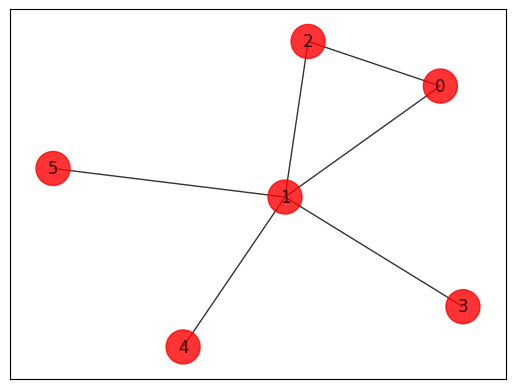

In [ ]:
# Generating a graph of 4 nodes

n = 6  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
edges = [(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (1, 3, 1.0), (1, 4, 1.0), (1, 5, 1.0)]
G.add_weighted_edges_from(edges)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

draw_graph(G, colors, pos)

**Minimum Vertex Cover Models**

Given an undirected unweighted Graph $G$ with vertex set $V$ with vertices $i$ and edge set $E$ with edges $(i, j)$ the corresponding Ising Hamiltonian is:

$$H=P\sum_{(i, j) \in E}(1-s_{i})(1-s_{j}) + \sum_{i \in V}s_{i}$$

Where $s_{i} \in \{-1,1\}$ is the Ising spin variable and $P$ is the penalty coefficient.

The corresponding QUBO Model is:

$$Q=\sum_{i \in V}x_{i} + P(\sum_{(i, j) \in E}(1-x_{i}-x_{j}+x_{i}x_{j}))$$

Where $x_{i} \in \{0, 1\}$ is a binary quadratic variable.

Note in the example $P$ was chosen through trial-and-error although there exists rigorous mathematical processes

In [ ]:
x = Array.create('x', n, 'BINARY')
P = 0.5
H = sum(x[i] for i in range(n)) + P*sum(1 - x[e[0]] - x[e[1]] + x[e[0]]*x[e[1]] for e in edges)
model = H.compile()
bqm = model.to_bqm()

Embedding and solving the problem on a DWAVE Quantum Annealer.

In [ ]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample(bqm, num_reads=1000)
sample = sampleset.first

Print sampler solving details.

In [ ]:
print(sampleset.info)
elapsed_time = float(sampleset.info['timing']['qpu_access_time'])/1000000

{'timing': {'qpu_sampling_time': 98280.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 57.74, 'qpu_access_time': 114039.57, 'qpu_access_overhead_time': 1676.43, 'qpu_programming_time': 15759.57, 'qpu_delay_time_per_sample': 20.54, 'total_post_processing_time': 272.0, 'post_processing_overhead_time': 272.0}, 'problem_id': '080a733d-92b2-4163-b967-0798a22e4649'}


In [ ]:
#Sorts samples by numbers to see which quadratic variables are 0 and 1
sampleKeys = list(sample.sample.keys())
sampleKeys.sort(key = sortbynumber)
sortedSample = {i: sample.sample[i] for i in sampleKeys}
print(sortedSample)

{'x[0]': 0, 'x[1]': 1, 'x[2]': 0, 'x[3]': 0, 'x[4]': 0, 'x[5]': 0}


In [ ]:
# Converting the output binary variables to produce a valid output
def MVC(sortedSample):
  mvc_sol = []
  for i in sortedSample.keys():
    if sortedSample[i] == 0:
        mvc_sol.append(0)
    else:
        mvc_sol.append(1)
  colors = ["r" if mvc_sol[i] == 0 else "c" for i in range(len(mvc_sol))]
  draw_graph(G, colors, pos)
  covered = 0
  for u, v in G.edges():
    if mvc_sol[u] == 1 or mvc_sol[v] == 1:
      covered += 1
  return covered

QPU Access Time: 0.11403957
5


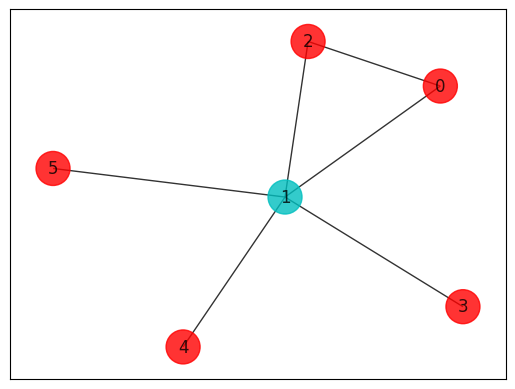

In [ ]:
print("QPU Access Time: " + str(elapsed_time))
print(MVC(sortedSample))

### **Example 4 - Cancer Genomics**

Identifying Cancer Gene Pathways from the TCGA-AML Data. The techniques used were taken from: https://www.biorxiv.org/content/10.1101/845719v1

In [ ]:
# import necessary package for data imports
from bravado.client import SwaggerClient
from itertools import combinations

# connects to cbioportal to access data
cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/v2/api-docs',
                                    config={"validate_requests":False,"validate_responses":False,"validate_swagger_spec":False})

Accessing AML study data from the cbioportal.

In [ ]:
# accesses cbioportal's AML study data
aml = cbioportal.Cancer_Types.getCancerTypeUsingGET(cancerTypeId='aml').result()

# access the patient data of AML study
patients = cbioportal.Patients.getAllPatientsInStudyUsingGET(studyId='laml_tcga').result()

# for each mutation, creates a list of properties associated with the mutation include geneID, patientID, and more
InitialMutations = cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET(
    molecularProfileId='laml_tcga_mutations',
    sampleListId='laml_tcga_all',
    projection='DETAILED'
).result()

Identifying the 33 most common genes from the study.

Then preprocessing the data to create a Patient-Gene Dictionary to construct the matrices from.

In [ ]:
# tests if data is correct
# Compares the frequency of the 33 most common genes and compares them with the information listed on
# https://www.cbioportal.org/study/summary?id=laml_tcga
from collections import Counter
mutation_counts = Counter([m.gene.hugoGeneSymbol for m in InitialMutations])
MostImportantMutationsCounts = mutation_counts.most_common(33)
MostImportantMutations = []
for i in range(len(MostImportantMutationsCounts)):
    MostImportantMutations.append(MostImportantMutationsCounts[i][0])

In [ ]:
# Sort the patients by index
def sortPatients(m):
    return m.patientId

In [ ]:
mutations = []
for m in InitialMutations:
    if m.gene.hugoGeneSymbol in MostImportantMutations:
        mutations.append(m)
geneset = set()

for m in mutations:
    geneset.add(m.gene.hugoGeneSymbol)
# creates a patient-(gene-list) dictionary

PatientGeneDict = {}
mutations.sort(key = sortPatients)

for m in mutations:
    if m.patientId in PatientGeneDict.keys(): # if the patient is already in dictionary add the gene to their previous gene list
        PatientGeneDict[m.patientId].append(m.gene.hugoGeneSymbol)
    else:
        PatientGeneDict[m.patientId] = [m.gene.hugoGeneSymbol] # else add the patient their associated gene

In [ ]:
# create independent patient and gene lists
patientset = set()
for m in mutations:
    patientset.add(m.patientId)
patientList = [] # patient list
for m in patientset:
    patientList.append(m)
geneList = [] # gene list
for gene in geneset:
    geneList.append(gene)
geneList.sort()

In [ ]:
for key in PatientGeneDict:
    PatientGeneDict[key] = list(set(PatientGeneDict[key]))

Patient-Gene Dictionary that displays each patient and their corresponding gene-list.

In [ ]:
# Organized way to visualize the patient-(gene-list) dictionary
print("Patient-Gene Dictionary:")
for k in PatientGeneDict.keys():
    print(k)
    print(PatientGeneDict[k])

Patient-Gene Dictionary:
TCGA-AB-2802
['PTPN11', 'DNMT3A', 'IDH1', 'NPM1', 'MT-ND5']
TCGA-AB-2804
['PHF6']
TCGA-AB-2805
['RUNX1', 'IDH2']
TCGA-AB-2806
['PLCE1']
TCGA-AB-2807
['RUNX1', 'ASXL1', 'IDH2']
TCGA-AB-2808
['CEBPA', 'NRAS']
TCGA-AB-2809
['DNMT3A', 'NPM1']
TCGA-AB-2810
['NPM1', 'IDH2']
TCGA-AB-2811
['DNMT3A', 'NPM1', 'FLT3', 'SMC1A']
TCGA-AB-2812
['NPM1', 'FLT3']
TCGA-AB-2813
['CACNA1B', 'TP53']
TCGA-AB-2814
['CACNA1B', 'MT-CO2', 'FLT3']
TCGA-AB-2816
['DNMT3A', 'NPM1', 'FLT3', 'NRAS']
TCGA-AB-2817
['EZH2', 'BRINP3', 'MT-ND5']
TCGA-AB-2818
['DNMT3A', 'NPM1', 'FLT3', 'RAD21']
TCGA-AB-2819
['KIT']
TCGA-AB-2820
['MT-CO2', 'TP53']
TCGA-AB-2821
['ASXL1', 'RUNX1', 'U2AF1', 'IDH1', 'IDH2']
TCGA-AB-2822
['DNMT3A', 'TET2', 'IDH1', 'SMC1A']
TCGA-AB-2824
['DNMT3A', 'NPM1', 'SMC1A']
TCGA-AB-2825
['DNMT3A', 'NPM1', 'FLT3']
TCGA-AB-2826
['NPM1', 'KRAS', 'IDH2']
TCGA-AB-2829
['TP53']
TCGA-AB-2830
['DNMT3A', 'TET2', 'FLT3']
TCGA-AB-2831
['DNMT3A']
TCGA-AB-2833
['DNMT3A']
TCGA-AB-2834
['FLT3']
TC

Create the diagonal $D$ matrix to represent gene-coverage.

In [ ]:
import numpy as np
D = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i == j:
            count = 0
            for k in PatientGeneDict.keys():
                if geneList[i] in PatientGeneDict[k]:
                    count += 1
            D[i][j] = count

Generate gene pairs to create the $A_w$ exclusivity matrix

In [ ]:
def generate_pairs(lst):
    pairs = set()
    for subset in combinations(lst, 2):
        pairs.add(tuple(sorted(subset)))
    return pairs

Using the patient-gene dictionary, we identify all gene-pairs for each patient. This used to create the $A_w$ matrix.

In [ ]:
# creates a patient-(gene-list-pair) dictionary
PatientGeneDictPairs = {}
for m in mutations:
        PatientGeneDictPairs[m.patientId] = generate_pairs(PatientGeneDict[m.patientId])

With all the preprocessing done, the $A_w$ matrix is completed.

In [ ]:
# creates the A_w exclusivity matrix
A_w = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            count = 0
            for k in PatientGeneDict.keys():
                if (geneList[i], geneList[j]) in PatientGeneDictPairs[k]:
                    count += 1
            A_w[i][j] = count
# ensures that A_w matrix is symmetric
for i in range(n):
    for j in range(n):
        A_w[i][j] = max(A_w[i][j], A_w[j][i])
        A_w[j][i] = max(A_w[i][j], A_w[j][i])

Identify properties from the gene pathway:

In [ ]:
# returns the coverage of a gene
def gene_coverage(gene):
    return D[geneList.index(gene)][geneList.index(gene)]

In [ ]:
# returns the coverage of a pathway
def coverage(pathway):
    coverage_val = 0
    for i in pathway:
        coverage_val += gene_coverage(i)
    return coverage_val

In [ ]:
# returns the indepence(exclusivity) of a pathway
def indep(pathway):
    num_overlap = 0
    for i in pathway:
        for j in pathway:
            if i == j:
                pass
            else:
                num_overlap += A_w[geneList.index(i)][geneList.index(j)]
    return num_overlap

Using the $A_w$ and $D$ matrices, we create the QUBO to identify the Cancer Genes. As stated in "Quantum and Quantum-inspired Methods for de novo
Discovery of Altered Cancer Pathways", the QUBO formulation to identify the cancer gene set while balancing Indepence and Coverage is:

$$Q=\mathbf{x}^{T}(A_{w}-\alpha D)\mathbf{x}$$

Where $D$ and $A_w$ are the previously found matrices and $\mathbf{x}$ is the vector of binary variables $x_{i}$

In [ ]:
# initializes an array of QUBO variables
x = Array.create('x', n, 'BINARY')
H1 = sum(sum(A_w[i][j]*x[i]*x[j] for j in range(n)) for i in range(n))
H2 = sum(D[i][i]*x[i] for i in range(n))
a = Placeholder("alpha")
H = H1 - a*H2

Embedding and solving the problem on a DWAVE Quantum Annealer.

In [ ]:
# creates a Hamiltonian to run on DWAVE sampler
model = H.compile()
feed_dict = {'alpha': 0.45}
bqm = model.to_bqm(feed_dict=feed_dict)

In [ ]:
# Getting Results from Sampler
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample(bqm, num_reads=1000)
sample = sampleset.first

Print sampler solving details.

In [ ]:
print(sampleset.info)
sampleKeys = list(sample.sample.keys())
def sortbynumber(str):
    return int(str[2:len(str)-1])
sampleKeys.sort(key = sortbynumber)
sortedSample = {i: sample.sample[i] for i in sampleKeys}

{'timing': {'qpu_sampling_time': 113120.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 72.58, 'qpu_access_time': 128879.97, 'qpu_access_overhead_time': 2996.03, 'qpu_programming_time': 15759.97, 'qpu_delay_time_per_sample': 20.54, 'total_post_processing_time': 507.0, 'post_processing_overhead_time': 507.0}, 'problem_id': 'c6a95b8e-cb48-4ce7-b2af-83e67315e9e7'}


Print the identified pathway

In [ ]:
pathway = []
for i in sampleKeys:
    if sortedSample[i] == 1:
        pathway.append(geneList[int(i[2:len(i)-1])])
print(pathway)
print("coverage: " + str(coverage(pathway)))
print("coverage/gene: " + str(round(coverage(pathway)/len(pathway), 2)))
print("indep: " + str(indep(pathway)))
print("measure: " + str(round(coverage(pathway)/len(pathway)/indep(pathway), 2)))

['ASXL1', 'BRINP3', 'CACNA1B', 'CACNA1E', 'CEBPA', 'COL12A1']
coverage: 32.0
coverage/gene: 5.33
indep: 0.0
measure: inf


<ipython-input-44-ebed2a313054>:9: RuntimeWarning: divide by zero encountered in double_scalars
  print("measure: " + str(round(coverage(pathway)/len(pathway)/indep(pathway), 2)))


### **Example 5 - Hedge Fund Applications**

As derived in the main paper, the Order Partitioning QUBO is of the form:

$$Q=a(T-2\sum_{j=1}^{n}q_{j}x_{j})^2 + b\sum_{i=1}^{m}(\sum_{j=1}^{n}p_{ij}(2x_{j}-1))^2$$

Where $T$ is the sum of the stock values, $q_{j}$ are the stocks and $p_{ij}$ are the risk factor matrix entries

Creating parameters for the Order Partitioning Problem.

In [ ]:
Stocks = ['A', 'B', 'C', 'D', 'E', 'F']
stock_vals = [300, 100, 100, 200, 200, 100]
#solutions S1 = {100,100,100,200} and S2 = {200,300} or S1 = {300,100,100} and S2 = {200,200,100}.
risk_factor_matrix = [[0.3, 0.1, 0.1, 0.2, 0.2, 0.1],
                      [0.4, 0.05, 0.05, 0.12, 0.08, 0.3],
                      [0.1, 0.2, 0.2, 0.3, 0.05, 0.05]]
T = sum(stock_vals)
n = 6 # number of stocks
m = 3 # number of risk factors

We create the Order Partitioning QUBO.

In [ ]:
x = Array.create('x', n, 'BINARY')
H1 = (T - 2*sum(stock_vals[j]*x[j] for j in range(n)))**2
H2 = sum(sum(risk_factor_matrix[i][j]*(2*x[j]-1)**2 for j in range(n)) for i in range(m))

# Construct hamiltonian
a = Placeholder("a")
b = Placeholder("b")
H = a*H1 + b*H2
model = H.compile()

# Generate QUBO
feed_dict = {'a': 2, 'b': 2}
bqm = model.to_bqm(feed_dict=feed_dict)

In [ ]:
# Construct hamiltonian
a = Placeholder("a")
b = Placeholder("b")
H = a*H1 + b*H2
model = H.compile()

In [ ]:
# Generate QUBO
feed_dict = {'a': 2, 'b': 2}
bqm = model.to_bqm(feed_dict=feed_dict)

We solve the QUBO using the Quantum Annealing Sampler.

In [ ]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample(bqm, num_reads=1000)
sample = sampleset.first # gets lowest energy sample

We display the solving details and solution.

In [ ]:
#Sorts samples by numbers to see which quadratic variables are 0 and 1
sampleKeys = list(sample.sample.keys())
def sortbynumber(str):
    return int(str[2:len(str)-1])
sampleKeys.sort(key = sortbynumber)
sortedSample = {i: sample.sample[i] for i in sampleKeys}
print(sortedSample)
print(sampleset.info)

{'x[0]': 0, 'x[1]': 1, 'x[2]': 1, 'x[3]': 0, 'x[4]': 1, 'x[5]': 1}
{'timing': {'qpu_sampling_time': 114320.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 73.78, 'qpu_access_time': 130080.77, 'qpu_access_overhead_time': 789.23, 'qpu_programming_time': 15760.77, 'qpu_delay_time_per_sample': 20.54, 'total_post_processing_time': 557.0, 'post_processing_overhead_time': 557.0}, 'problem_id': 'f34c1f6e-ddcd-46d6-95ac-049cefb49684'}


In [ ]:
# Converting the output binary variables to produce a valid output
Set_A = []
net_cost_A = 0
net_risk_1A = 0
net_risk_2A = 0
net_risk_3A = 0
Set_B = []
net_cost_B = 0
net_risk_1B = 0
net_risk_2B = 0
net_risk_3B = 0
keylist = list(sortedSample.keys())
for i in range(0, len(keylist)):
  if(sortedSample[keylist[i]] == 0):
    Set_A.append(Stocks[i])
    net_cost_A += stock_vals[i]
    net_risk_1A += risk_factor_matrix[0][i]
    net_risk_2A += risk_factor_matrix[1][i]
    net_risk_3A += risk_factor_matrix[2][i]
  else:
    Set_B.append(Stocks[i])
    net_cost_B += stock_vals[i]
    net_risk_1B += risk_factor_matrix[0][i]
    net_risk_2B += risk_factor_matrix[1][i]
    net_risk_3B += risk_factor_matrix[2][i]
print("Stock Partition: ", Set_A, Set_B)
print("Difference of Net Cost between Partition: ", net_cost_A-net_cost_B)
print("Difference of Net Risk between Partition: ", round((net_risk_1A+net_risk_2A+net_risk_3A)-(net_risk_1B+net_risk_2B+net_risk_3B),2))

Stock Partition:  ['A', 'D'] ['B', 'C', 'E', 'F']
Difference of Net Cost between Partition:  0
Difference of Net Risk between Partition:  -0.06
